In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter
from datetime import datetime


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_pie

In [25]:
# Download PUF zip
# URLs obtained by following transparency in coverage PUF links at: https://www.cms.gov/cciio/resources/data-resources/marketplace-puf
year = 2023
url = (
    f"https://download.cms.gov/marketplace-puf/{year}/transparency-in-coverage-puf.zip"
)
puf_zip_path = f"transparency_in_coverage_puf_{year}.zip"
download_file_from_url(url, puf_zip_path)

# Unzip
zipdata = zipfile.ZipFile(puf_zip_path)
zipinfo = zipdata.infolist()[0]  # Single file in each zip

# Rename file to enforce consistency across years and handle with same boilerplate
zipinfo.filename = f"transparency_in_coverage_puf_{year}.xlsx"
puf_path = zipdata.extract(zipinfo)

# Delete zip
os.remove(puf_zip_path)

Success.


### Helper Functions


In [31]:
def read_and_split_puf_sheet(puf_path, sheet_name):
    """Split off the title, legend and actual data from CMS puf sheet."""
    df = pd.read_excel(puf_path, engine="openpyxl", sheet_name=sheet_name)
    title = df.keys()[0]
    legend = df.iloc[0][0]

    # reassign header
    data = df.iloc[1:]
    headers = data.iloc[0]
    data = data[1:]
    data.columns = headers

    return title, legend, data


def get_issuer_level_dfs(dfs):
    """Isolate a dataframe containing all issuer level data for each df in dfs."""
    issuer_level_dfs = []
    for df in dfs:
        issuer_const_cols = [
            "Issuer_ID",
            "State",
            "Issuer_Name",
            "Is_Issuer_New_to_Exchange? (Yes_or_No)",
            "SADP_Only?",
            "QHP/SADP",
            "Issuer_Claims_Received",
            "Issuer_Claims_Denials",
            "Issuer_Internal_Appeals_Filed",
            "Issuer_Number_Internal_Appeals_Overturned",
            "Issuer_External_Appeals_Filed",
            "Issuer_Number_External_Appeals_Overturned",
        ]
        issuer_level_df = df.groupby(issuer_const_cols, as_index=False).first()
        issuer_level_df = issuer_level_df[issuer_const_cols]
        issuer_level_dfs.append(issuer_level_df)
    return issuer_level_dfs


def get_denial_rate(
    row, recvd_col="Issuer_Claims_Received", denied_col="Issuer_Claims_Denials"
):
    recvd = row[recvd_col]
    denied = row[denied_col]
    if type(recvd) is str and type(denied) is str:
        return int(denied) / int(recvd)
    if type(recvd) is int and type(denied) is int:
        return denied / recvd
    else:
        return -1

### Read Data


In [32]:
# The Qualified Health Plan (QHP) data is delivered as a sheet in an xlsx file, but with a title row and legend row,
# which makes parsing this as a dataframe unnecessarily involved. Why CMS, just why? A humble request: can document the legend and title
# in a separate file or readme moving forward, so that the data can be read without having to study the header formats that vary year to year?
sheet_name = f"Transparency {year} - Ind QHP"
title, legend, df = read_and_split_puf_sheet(puf_path, sheet_name)

In [33]:
# Legend
print(f"{title}\n\n{legend}")

Individual Marketplace Medical Qualified Health Plans (QHPs)

Legend 
*                              Data not available for this issuer/plan
**                            Suppressed data due to small cell sizes                  
***                          Data not required due to plan type
N/A                         Data not applicable because issuer or plan offering is new to the Exchange
Missing URL            Financial Link unavailable on NAIC website


### Clean and Group Data


In [50]:
def filter_rows_missing_data(
    df,
    cols=[
        "Issuer_Claims_Received",
        "Issuer_Claims_Denials",
        "Issuer_Internal_Appeals_Filed",
        "Issuer_Number_Internal_Appeals_Overturned",
        "Issuer_External_Appeals_Filed",
        "Issuer_Number_External_Appeals_Overturned",
    ],
    disallowed_values=["*", "**"],
):
    """Filter out rows for which any of the input columns contain null, * or ** values."""

    # Filter out null and disallowed strs
    filtered_df = df.copy(deep=True)
    for col in cols:
        pre_len = len(filtered_df)
        filtered_df = filtered_df[
            ~(filtered_df[col].isnull() | filtered_df[col].isin(disallowed_values))
        ]
        removed_rows = pre_len - len(filtered_df)
        if removed_rows > 0:
            print(
                f"Removed {removed_rows} rows for which column '{col}' is null or in {disallowed_values}"
            )

    return filtered_df

def cast_to_int(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Cast list of specified columns in df to int.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe on which to cast types.
    cols : list[str]
        Columns in dataframe.

    Returns
    -------
    pd.DataFrame
        Dataframe with updated types.
    """
    conversion_dict = {name: int for name in cols}
    df = df.astype(conversion_dict)
    return df


def filter_erroneous_issuer_claims(df):
    """Filter issuer rows for which claims received are less than claims denied.
    """
    pre_len = len(df)
    filtered_df = df[
        df["Issuer_Claims_Received"] > df["Issuer_Claims_Denials"]
    ]
    removed_rows = pre_len - len(filtered_df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows reporting more denials than claims.")

    return filtered_df

def filter_erroneous_plan_claims(df):
    """Filter plan for which claims received are less than claims denied.
    """
    pre_len = len(df)
    filtered_df = df[
        df["Issuer_Claims_Received"] > df["Issuer_Claims_Denials"]
    ]
    removed_rows = pre_len - len(filtered_df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows reporting more denials than claims.")

    return filtered_df


def isolate_medical(df):
    df = df[df["SADP_Only?"] == "No"]
    return df


def isolate_QHP(df):
    df = df[df["QHP/SADP"] == "QHP"]
    return df

In [51]:
# Isolate QHP medical plans
df = isolate_medical(df)
df = isolate_QHP(df)

In [57]:
# Isolate issuers with denial rate data.
base_cols = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]
issuer_claims_cols = base_cols + [
        "Issuer_Internal_Appeals_Filed",
        "Issuer_Number_Internal_Appeals_Overturned",
        "Issuer_External_Appeals_Filed",
        "Issuer_Number_External_Appeals_Overturned",
    ]
issuer_filtered_df = filter_rows_missing_data(
    df,
    cols=base_cols,
    disallowed_values = ["*", "**"]
)
issuer_filtered_df = cast_to_int(issuer_filtered_df, base_cols)
issuer_filtered_df = filter_erroneous_issuer_claims(issuer_filtered_df)
issuer_df = get_issuer_level_dfs([issuer_filtered_df])[0]

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']


In [ ]:
# Isolate issuers with denial rate + internal appeal result data
internal_cols = base_cols + [        "Issuer_Internal_Appeals_Filed",
        "Issuer_Number_Internal_Appeals_Overturned",]
issuer_filtered_df = filter_rows_missing_data(
    df,
    cols=internal_cols,
    disallowed_values = ["*", "**"]
)
issuer_filtered_df = cast_to_int(issuer_filtered_df, internal_cols)
issuer_filtered_df = filter_erroneous_issuer_claims(issuer_filtered_df)
issuer_df = get_issuer_level_dfs([issuer_filtered_df])[0]

In [ ]:
# Isolate relevant plan level data
# plan_filtered_df = filter_rows_missing_data(
#     df,
#     cols=[
#         "Issuer_Claims_Received",
#         "Issuer_Claims_Denials",
#         "Issuer_Internal_Appeals_Filed",
#         "Issuer_Number_Internal_Appeals_Overturned",
#         "Issuer_External_Appeals_Filed",
#         "Issuer_Number_External_Appeals_Overturned",
#     ],
# )
# issuer_filtered_df = filter_erroneous_issuer_claims(issuer_filtered_df)
# issuer_df = get_issuer_level_dfs([issuer_filtered_df])[0]

### High Level Stats


In [ ]:
print(f"{len(issuer_df)} issuers reporting data sufficient to calculate denial rate.")

In [49]:
print(f"{len(df)} rows")
print(f"{len(issuer_df['Issuer_ID'].unique())} unique issuers.")

6764 rows
164 distinct claims received values
230 unique issuer IDs


In [ ]:
# Reproduce KFF Pie Chart
total_claims_received = (
    issuer_df[~issuer_df["Issuer_Claims_Received"].isnull()]["Issuer_Claims_Received"]
    .astype(int)
    .sum()
)
total_claims_denied = (
    issuer_df[~issuer_df["Issuer_Claims_Denials"].isnull()]["Issuer_Claims_Denials"]
    .astype(int)
    .sum()
)

# Question: Can we find average price of a claim, to make some monetary, back of envelope calculations here?

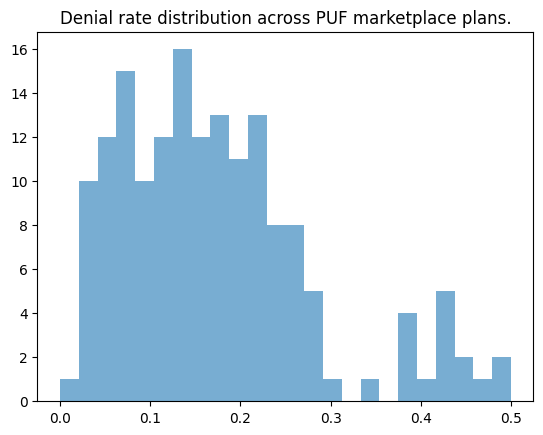

In [56]:
# Calculate denial rates where possible
issuer_df["denial_rate"] = issuer_df.apply(issuer_denial_rate, axis=1)
denial_rates = issuer_df[issuer_df["denial_rate"] != -1]

# Plot hist of received claims
fig, ax = plt.subplots()
ax.set_title("Denial rate distribution across PUF marketplace plans.")
ax.hist(denial_rates["denial_rate"], alpha=0.6, bins=np.linspace(0, 0.5, 25))
plt.show()

# Plot hist of denied claims
fig, ax = plt.subplots()
ax.set_title("Denial rate distribution across PUF marketplace plans.")
ax.hist(denial_rates["denial_rate"], alpha=0.6, bins=np.linspace(0, 0.5, 25))
plt.show()

# Plot hist of denial rate:
fig, ax = plt.subplots()
ax.set_title("Denial rate distribution across PUF marketplace plans.")
ax.hist(denial_rates["denial_rate"], alpha=0.6, bins=np.linspace(0, 0.5, 25))
plt.show()

In [59]:
# Federal marketplace states

# Num issuers represented
issuer_df["State"].value_counts()

# Num enrolees represented

# Num claims represented

# Estimate of value represented


# Q: How do denial rates compare on federal marketplace plans vs state marketplaces? Worst offenders?

TX    19
FL    16
WI    13
OH    12
VA    12
NC    11
IL    11
GA    11
MI    10
MO    10
AZ     9
KS     8
OK     7
TN     7
UT     6
OR     6
LA     6
NE     5
SC     5
IN     5
MS     5
AR     5
AL     4
IA     4
NH     3
ND     3
DE     3
SD     3
MT     3
WV     2
AK     2
WY     2
HI     2
Name: State, dtype: int64

In [ ]:
# General utilities
def isolate_complete_issuers(df):
    pass


def isolate_complete_plans(df):
    pass


def isolate_medical(df):
    df = df[df["SADP_Only?"] == "No"]
    return df


def isolate_QHP(df):
    df = df[df["QHP/SADP"] == "QHP"]
    return df


def clean(data, year):
    "Clean and return numerical data"

    # Add plan year as convenience:
    data["denial_stats_year"] = year

    if year == 2023:
        integral_columns = [
            "Issuer_Claims_Received",
            "Issuer_Claims_Denials",
            "Issuer_Internal_Appeals_Filed",
            "Issuer_Number_Internal_Appeals_Overturned",
            "Issuer_Percent_Internal_Appeals_Overturned",
            "Issuer_External_Appeals_Filed",
            "Issuer_Number_External_Appeals_Overturned",
            "Issuer_Percent_External_Appeals_Overturned",
            "Plan_Number_Claims_Received",
            "Plan_Number_Claims_Denied",
            "Plan_Number_Claims_Denied_Referral_Required",
            "Plan_Number_Claims_Denied_Out_of_Network",
            "Plan_Number_Claims_Denied_Services_Excluded",
            "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health",
            "Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only",
            "Plan_Number_Claims_Denied_Other",
            "Average Monthly Enrollment",
            "Average Monthly Disenrollment",
        ]
        other_columns = [
            "State",
            "Issuer_Name",
            "Issuer_ID",
            "Is_Issuer_New_to_Exchange? (Yes_or_No)",
            "SADP_Only?",
            "Plan_ID",
            "QHP/SADP",
            "Plan_Type",
            "Metal_Level",
        ]
        not_null_columns = []

    if year == 2021:
        # 2021 numerical columns
        integral_columns = [
            "Issuer_ID",
            "Issuer_Name",
            "Issuer_Claims_Received",
            "Issuer_Claims_Denials",
            "Issuer_Internal_Appeals_Filed",
            "Issuer_Number_Internal_Appeals_Overturned",
            "Issuer_Percent_Internal_Appeals_Overturned",
            "Issuer_External_Appeals_Filed",
            "Issuer_Number_External_Appeals_Overturned",
            "Issuer_Percent_External_Appeals_Overturned",
            "Plan_Number_Claims_Received",
            "Plan_Number_Claims_Denied",
            "Plan_Number_Claims_Denied_Referral_Required",
            "Plan_Number_Claims_Denied_Out_of_Network",
            "Plan_Number_Claims_Denied_Services_Excluded",
            "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health",
            #'Plan_Number_Claims_Denied_Not_Medically_Necessary_Incl_Behavioral_Health',
            "Plan_Number_Claims_Denied_Other",
            "Enrollment_Data",
            "Disenrollment_Data",
        ]
        not_null_columns = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]

    if year == 2020:
        # 2020 numerical columns
        integral_columns = [
            "Issuer_ID",
            "Issuer_Name",
            "Issuer_Claims_Received",
            "Issuer_Claims_Denials",
            "Issuer_Internal_Appeals_Filed",
            "Issuer_Number_Internal_Appeals_Overturned",
            "Issuer_Percent_Internal_Appeals_Overturned",
            "Issuer_External_Appeals_Filed",
            "Issuer_Number_External_Appeals_Overturned",
            "Issuer_Percent_External_Appeals_Overturned",
            "Plan_Number_Claims_Received",
            "Plan_Number_Claims_Denied",
            "Plan_Number_Claims_Denied_Referral_Required",
            "Plan_Number_Claims_Denied_Out_of_Network",
            "Plan_Number_Claims_Denied_Services_Excluded",
            "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health",
            #'Plan_Number_Claims_Denied_Not_Medically_Necessary_Incl_Behavioral_Health',
            "Plan_Number_Claims_Denied_Other",
            "Enrollment_Data",
            "Disenrollment_Data",
        ]
        not_null_columns = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]

    if (year == 2019) or (year == 2018):
        # 2019 numerical columns
        integral_columns = [
            "Issuer_ID",
            "Issuer_Name",
            "Claims_Received",
            "Claims_Denials",
            "Internal_Appeals Filed",
            "Number_Internal_Appeals_Overturned",
            "Percent_Internal_Appeals_Overturned",
            "External Appeals Filed",
            "Number_External_Appeals_Overturned",
            "Percent_External_Appeals_Overturned",
            "Enrollment_Data",
            "Disenrollment_Data",
        ]
        not_null_columns = ["Claims_Received", "Claims_Denials"]

    # Get non NA values for now
    if year in [2018, 2019]:
        nm_data = data[integral_columns + ["State"]].dropna()
    if year in [2020, 2021]:
        nm_data = data[integral_columns + ["State", "Plan_ID"]].dropna()

    if year in [2018, 2019]:
        nm_data = nm_data[~nm_data["Claims_Received"].isin(["*", "**"])]
        nm_data = nm_data[~nm_data["Claims_Denials"].isin(["*", "**"])]
    if year in [2020, 2021, 2023]:
        nm_data = nm_data[~nm_data["Issuer_Claims_Received"].isin(["*", "**"])]
        nm_data = nm_data[~nm_data["Issuer_Claims_Denials"].isin(["*", "**"])]
    # Remove rows where claims are less than denials, some bug in reporting:
    if (year == 2019) or (year == 2018):
        nm_data = nm_data[nm_data["Claims_Received"] > nm_data["Claims_Denials"]]
    # Remove erroneous cases of claims received > claims_denied
    if (year == 2020) or (year == 2021) or (year == 2023):
        nm_data = nm_data[
            nm_data["Issuer_Claims_Received"] > nm_data["Issuer_Claims_Denials"]
        ]

    for column in integral_columns:
        nm_data[f"{column}"] = pd.to_numeric(nm_data[f"{column}"], errors="coerce")
    for column in not_null_columns:
        nm_data = nm_data[nm_data[f"{column}"].notna()]
        nm_data[f"{column}"] = nm_data[f"{column}"].astype(int)

    if (year == 2019) or (year == 2018):
        nm_data = nm_data[nm_data["Claims_Received"] > 1000]

    if (year == 2020) or (year == 2021):
        nm_data = nm_data[nm_data["Issuer_Claims_Received"] > 1000]
    return nm_data


def get_issuer_level_dfs(dfs):
    issuer_level_dfs = []
    for df in dfs:
        issuer_level_df = df.groupby("Issuer_ID").first()
        issuer_level_dfs.append(issuer_level_df)
    return issuer_level_dfs


def get_plan_level_dfs(dfs):
    plan_level_dfs = []
    for df in dfs:
        plan_level_df = df.groupby("Plan_ID").first()
        plan_level_dfs.append(plan_level_df)
    return plan_level_dfs

In [ ]:
df["Issuer_Claims_Received"].isna().sum()

In [ ]:
# Motivating Questions Across Data Sources


# Plot denial rates by state, by year


# Plot denial rates by insurer, by year (how it is progressing?)


# Plot denial type by insurer, by state? What dominates for each insurer, where to focus?

# KFF looks only at insurers from marketplace with "complete" data.

# How often do consumers get denied?

# How often do they appeal?

# How often do they win appeals (internal)?

# How often do they external appeal?

# How often do they win appeals (external)?

# How often do they win, period?

In [ ]:
## TODO From this:

1. Create a Deck (Persius MO).
2. Write a detailed report (like KHN) +  arxiv paper.
3. Write a blog post.
4. Publish CT data, other data summaries?